In [ ]:
# Load observational data
data_observe = pd.read_excel('Hydrostatic Data with Nodes.xlsx')
data_observe_sample = data_observe.sample(frac=1, random_state=7)
x_data = data_observe_sample['x'].values  
y_data = data_observe_sample['y'].values 
sigma_data = data_observe_sample['sigma'].values  
degree = 10 
poly = PolynomialFeatures(degree)
X = np.column_stack((x_data, y_data))
X_poly = poly.fit_transform(X)
model = LinearRegression()
model.fit(X_poly, sigma_data)
coefficients = model.coef_
intercept = model.intercept_
sigma_pred = model.predict(X_poly)
r2 = r2_score(sigma_data, sigma_pred)
print(f"R-squared: {r2:.4f}")

df = pd.read_excel('Hydrostatic Data with Nodes.xlsx')
n = 400  
sampled_data = df.sample(n=n)
train_data, test_data = train_test_split(sampled_data, test_size=0.4, random_state=42)
x_train = np.array(train_data['x'].values).reshape(-1, 1)  # Extract the x values for training
y_train = np.array(train_data['y'].values).reshape(-1, 1)   # Extract the y values for training
sigma_train =np.array(train_data['sigma'].values).reshape(-1, 1)  # Extract the sigma values for training
x_test = np.array(test_data['x'].values).reshape(-1, 1)  # Extract the x values for testing
y_test = np.array(test_data['y'].values).reshape(-1, 1)  # Extract the y values for testing
sigma_test = np.array(test_data['sigma'].values).reshape(-1, 1) # Extract the sigma values for te
data_x=np.column_stack((x_train,y_train))
data_x=data_x
data_sigma=np.array(sigma_train)
test_x=np.column_stack((x_test,y_test))
test_x=test_x
test_sigma=np.array(sigma_test)
data = dde.data.dataset.DataSet(X_train=data_x, y_train=data_sigma, X_test=test_x, y_test=test_sigma)
layer_size = [2] + [60] * 10 + [1]  # 2 inputs (x, y ) -> hidden layers -> 1 output (σ)
activation = "relu"
initializer = "He normal"
net_sigma = dde.nn.FNN(layer_size, activation,initializer)
model_sigma = dde.Model(data, net_sigma)
model_sigma.compile("adam", lr=1e-4)
losshistory, train_state = model_sigma.train(epochs=1000)




In [2]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [ ]:
import os
os.environ['DDE_BACKEND'] = 'tensorflow'
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import deepxde as dde
import tensorflow as tf
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

N=1e7
L = 6e-2 #m
R= 4e-3 #m
t_last=1e6 #s
square = dde.geometry.Rectangle([0, 0], [L, L])
circle = dde.geometry.Disk([0, 0], R)
geom = dde.geometry.csg.CSGDifference(square, circle)
timedomain = dde.geometry.TimeDomain(0, t_last)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
Samp = geom.random_points(30000)
plt.figure(figsize=(6, 6))
plt.scatter(Samp[:, 0], Samp[:, 1], marker='o', label="2D Rectangle")
plt.title("2D Geometry: Rectangle [0, 1] x [0, 1]")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


df = pd.read_excel('Hydrostatic Data with Nodes.xlsx')
n = 400  
sampled_data = df.sample(n=n)
train_data, test_data = train_test_split(sampled_data, test_size=0.4, random_state=42)
x_train = np.array(train_data['x'].values).reshape(-1, 1)  # Extract the x values for training
y_train = np.array(train_data['y'].values).reshape(-1, 1)   # Extract the y values for training
sigma_train =np.array(train_data['sigma'].values).reshape(-1, 1)  # Extract the sigma values for training
x_test = np.array(test_data['x'].values).reshape(-1, 1)  # Extract the x values for testing
y_test = np.array(test_data['y'].values).reshape(-1, 1)  # Extract the y values for testing
sigma_test = np.array(test_data['sigma'].values).reshape(-1, 1) # Extract the sigma values for te
data_x=np.column_stack((x_train,y_train))
data_x=data_x
data_sigma=np.array(sigma_train)
test_x=np.column_stack((x_test,y_test))
test_x=test_x
test_sigma=np.array(sigma_test)
data = dde.data.dataset.DataSet(X_train=data_x, y_train=data_sigma, X_test=test_x, y_test=test_sigma)
layer_size = [2] + [60] * 10 + [1]  # 2 inputs (x, y ) -> hidden layers -> 1 output (σ)
activation = "relu"
initializer = "He normal"
net_sigma = dde.nn.FNN(layer_size, activation,initializer)
model_sigma = dde.Model(data, net_sigma)
model_sigma.compile("adam", lr=1e-5)
losshistory, train_state = model_sigma.train(epochs=5000)

data_observe = pd.read_excel('Hydrostatic Data with Nodes.xlsx')
data_observe_sample = data_observe.sample(frac=1, random_state=7)
x_data = data_observe_sample['x'].values  
y_data = data_observe_sample['y'].values 
sigma_data = data_observe_sample['sigma'].values  

net_sigma.trainable = False

ic = dde.icbc.IC(geomtime, lambda x: 20.0, lambda x, on_initial: on_initial, component=0)

def pde_C_L(x, y):
    D_L = 3.8e-11 #m^2/s
    V_H = 2e-6 #m^3/mole
    RT= 8.314*298 #J/mole
    Coe=(D_L*V_H)/(RT)
    C_L=y[:,0:1]
    Sig=y[:,1:2]
    dC_dt = dde.grad.jacobian(y, x, i=0, j=2)
    CL_x=dde.grad.jacobian( y, x, i=0, j=0)
    CL_y=dde.grad.jacobian( y, x, i=0, j=1)
    CL_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    CL_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    
    cor = x[:, :2]  # Extract spatial coordinates
    sigma_values = net_sigma(cor)/N
    h_sigma_t=dde.grad.jacobian(y,x,i=1,j=2)
    h_sigma_x=dde.grad.jacobian(y,x,i=1,j=0)
    h_sigma_y= dde.grad.jacobian(y,x,i=1,j=1)
    h_sigma_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    h_sigma_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)

    eq1 = (dC_dt - D_L * (CL_xx + CL_yy)+ Coe * N* (CL_x * h_sigma_x + CL_y * h_sigma_y + C_L * (h_sigma_xx + h_sigma_yy)))
    eq2= h_sigma_t
    eq3=Sig-sigma_values
    return [eq1, eq2,eq3]

data = dde.data.TimePDE(
    geomtime,
    pde_C_L, [ic],
    num_domain=500,
    num_boundary=500,
    num_initial=500,
    num_test=500,
    )

# Network for C_L
layer_size = [3] + [64] * 5 + [2]  
activation = "tanh"
initializer = "Orthogonal"
net_C_L = dde.nn.FNN(layer_size, activation, initializer)
model= dde.Model(data, net_C_L)
model.compile("adam", lr=1e-8)
losshistory, train_state = model.train(epochs=10000, display_every=1000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

: 

In [ ]:
sigmat=net_sigma([[0.01, 0.02]])
Test = model.predict([[0.01, 0.02,1]])

print(Test)
print(sigmat)


: 

Compiling model...
Building feed-forward neural network...
'build' took 0.056919 s

'compile' took 2.353895 s

Training model...

0         [2.23e+00]                        [2.20e+00]                        [2.01e-01]
1000      [4.06e-04]                        [4.77e-04]                        [3.00e-03]
2000      [1.44e-04]                        [1.72e-04]                        [2.18e-03]
3000      [2.96e-04]                        [3.40e-04]                        [2.66e-03]
4000      [7.65e-05]                        [1.24e-04]                        [1.16e-03]
5000      [4.76e-05]                        [9.79e-05]                        [6.83e-04]
6000      [3.90e-05]                        [9.35e-05]                        [6.49e-04]
7000      [5.05e-05]                        [1.16e-04]                        [9.46e-04]
8000      [3.04e-05]                        [9.25e-05]                        [8.14e-04]
9000      [2.76e-05]                        [9.03e-05]               

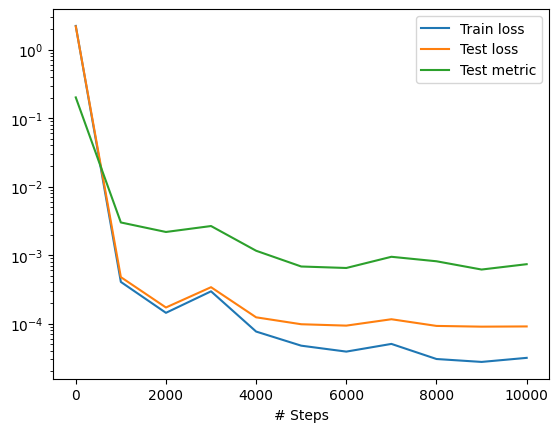

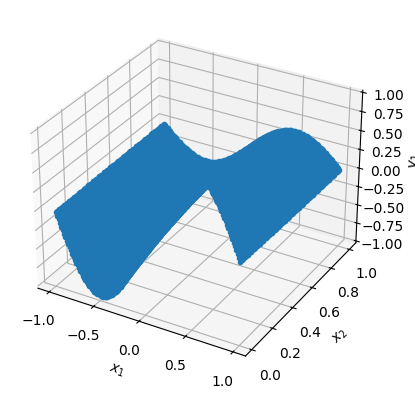

In [58]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import deepxde as dde
import numpy as np
# Backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
# Backend pytorch
# import torch
# Backend jax
# import jax.numpy as jnp
# Backend paddle
# import paddle


def pde(x, y):
    # Most backends
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    # Backend jax
    # dy_t, _ = dde.grad.jacobian(y, x, i=0, j=1)
    # dy_xx, _ = dde.grad.hessian(y, x, i=0, j=0)
    # Backend tensorflow.compat.v1 or tensorflow
    return (
        dy_t
        - dy_xx
        + tf.exp(-x[:, 1:])
        * (tf.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * tf.sin(np.pi * x[:, 0:1]))
    )
    # Backend pytorch
    # return (
    #     dy_t
    #     - dy_xx
    #     + torch.exp(-x[:, 1:])
    #     * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
    # )
    # Backend jax
    # return (
    #     dy_t
    #     - dy_xx
    #     + jnp.exp(-x[:, 1:])
    #     * (jnp.sin(np.pi * x[..., 0:1]) - np.pi ** 2 * jnp.sin(np.pi * x[..., 0:1]))
    # )
    # Backend paddle
    # return (
    #     dy_t
    #     - dy_xx
    #     + paddle.exp(-x[:, 1:])
    #     * (paddle.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * paddle.sin(np.pi * x[:, 0:1]))
    # )


def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

data = dde.data.TimePDE(geomtime, pde, [], num_domain=40, solution=func, num_test=10000)

layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
net.apply_output_transform(
    # Backend tensorflow.compat.v1 or tensorflow
    lambda x, y: x[:, 1:2] * (1 - x[:, 0:1] ** 2) * y + tf.sin(np.pi * x[:, 0:1])
    # Backend pytorch
    # lambda x, y: x[:, 1:2] * (1 - x[:, 0:1] ** 2) * y + torch.sin(np.pi * x[:, 0:1])
    # Backend jax
    # lambda x, y: x[..., 1:2] * (1 - x[..., 0:1] ** 2) * y + jnp.sin(np.pi * x[..., 0:1])
    # Backend paddle
    # lambda x, y: x[:, 1:2] * (1 - x[:, 0:1] ** 2) * y + paddle.sin(np.pi * x[:, 0:1])
)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)